In [30]:
import sys
from typing import List, Dict, Tuple
from data_tools import task_map, row_operations
from utils import persistence as ps
from urllib3.response import HTTPResponse
from pandas import DataFrame, Series, read_csv, concat, Grouper, melt, merge_asof, Timedelta, DatetimeIndex
import matplotlib.pyplot as plt
import seaborn as sns
from multiprocessing import Process, cpu_count
from error_handling import errors
from scipy import stats
from geo_merger import geo_merge, EXT
from numpy import array, empty, float64, zeros_like, triu_indices_from
from time import sleep
from functools import reduce

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
RGTRANSIT_BUCKET: str = 'rg-transit'
RGFARES_BUCKET: str = 'rg-tsfare'
RGGCABS_BUCKET: str = 'rg-gcabs'
RGYCABS_BUCKET: str = 'rg-ycabs'
RGTRAFFIC_BUCKET: str = 'rg-traffic'
REFBASE_BUCKET: str = 'ref-base'
GEOMERGED_PATH: str = 'geo-merged/'
PLOTS_BUCKET: str = 'plots'

MIN_INVW= 1 / 9.5
MAX_INVW = 1 / 0.5
RELPLOT_SZ_MULT = 1.5

BASE_COLOR='#34495E'
COLOR1='#E74C3C'
COLOR2='#2ECC71'

In [4]:
station_complex_map: Dict[str, str] = {
                                'BOWERY': 'BOWERY STREET-DELANCEY ST',
                                'WALL ST': 'WALL STREET',
                                'COURT SQ': 'COURT SQ',
                                '86 ST': '86TH STREET-4TH AVENUE',
                                'SOUTH FERRY': 'WHITEHALL STREET'
                              }
station_map: Dict[str, int] = {
                                'BOWERY': 103,
                                'WALL ST': 413,
                                'COURT SQ': 274,
                                '86 ST': 397,
                                'SOUTH FERRY': 330
                              }
weekday_map: Dict[int, str] = {
                                0 : 'Monday',
                                1 : 'Tuesday',
                                2 : 'Wednesday',
                                3 : 'Thursday',
                                4 : 'Friday',
                                5 : 'Saturday',
                                6 : 'Sunday'
                              }


In [5]:
geomerged_cabs: str = GEOMERGED_PATH+'/cabs.csv'
geomerged_traffic: str = GEOMERGED_PATH+'/traffic.csv'

# load ref-base geomerged files
filestream: HTTPResponse = ps.get_file_stream(bucket=REFBASE_BUCKET, filename=geomerged_cabs)
dtypes: Dict[str, str] = {
    'stop_name': 'object',
    'tsstation': 'object',
    'locationid': 'int64',
    'weight': 'float64'
}
geomerged_cabs_df: DataFrame = read_csv(filestream, usecols=dtypes.keys(), encoding='utf-8', dtype=dtypes)
geomerged_cabs_df = geomerged_cabs_df[~geomerged_cabs_df['locationid'].isna()]
filestream = ps.get_file_stream(bucket=REFBASE_BUCKET, filename=geomerged_traffic)
dtypes = {
    'stop_name': 'object',
    'tsstation': 'object',
    'linkid': 'float64',
    'weight': 'float64'
}
geomerged_traffic_df: DataFrame = read_csv(filestream, usecols=dtypes.keys(), encoding='utf-8', dtype=dtypes)
geomerged_traffic_df = geomerged_traffic_df[~geomerged_traffic_df['linkid'].isna()]

In [11]:
task = 'pl-1W-16-17'
freq = '1D'
filterby ='all'
filterval = ''
stations = ['BOWERY', 'WALL ST', 'COURT SQ', '86 ST', 'SOUTH FERRY']
station = stations[0]

In [15]:
range_: List[str] = task_map.task_type_map[task]['range']
start_date: str = range_[0]
end_date: str = range_[1]
# determine filename of transit data for
# the current station in the rg-transit bucket
# replace '/' in station with ' '
file_path: str = freq+'/'+filterby+filterval+'/'
ts_filename: str = file_path+station.replace('/', ' ').upper()

# read transit data for station (rg-transit bucket)
filestream = ps.get_file_stream(bucket=RGTRANSIT_BUCKET, filename=ts_filename)
ts_datecols = ['datetime']
dtypes = {
         'delex': 'int64',
         'delent': 'int64'
        }
transit_df = read_csv(filestream, usecols=ts_datecols + list(dtypes.keys()),
                                 parse_dates=ts_datecols,
                                 date_parser=row_operations.parse_rg_dt,
                                 encoding='utf-8', dtype=dtypes)
transit_df = transit_df.set_index('datetime').resample(freq).sum().loc[start_date: end_date]
transit_df.head()

,delex,delent
datetime,,
2016-01-01,3059,3133
2016-01-02,2980,2780
2016-01-03,2374,3051
2016-01-04,2353,3017
2016-01-05,2093,3020


In [13]:
def weighted_mean(group, weight_col):
    data_cols = [col for col in group.columns if col != weight_col]
    group_result = Series(empty(len(data_cols)), index=data_cols, dtype=float64)
    total_weight = group[weight_col].sum()
    for col in data_cols:
        group_result[col] = (group[col] * group[weight_col]).sum() / total_weight
    return group_result

In [14]:
cabs_datecols = ['dodatetime']

# determine relevant cabs files
# by finding dolocationids corresponding
# to current station from ref-base geomerged df
dolocationids = geomerged_cabs_df.loc[geomerged_cabs_df.tsstation == station][['locationid', 'weight']]

cabs_dtypes = {
    'dolocationid': 'int64',
    'passengers': 'int64',
    'distance': 'float64'
}

gcabs_df: DataFrame
gcabs_df = concat([read_csv(ps.get_file_stream(bucket=RGGCABS_BUCKET, filename=file_path+str(locationid)),
                            header=0,
                            usecols=cabs_datecols + list(cabs_dtypes.keys()),
                            parse_dates=cabs_datecols,
                            encoding='utf-8', dtype=cabs_dtypes)
                   for locationid in dolocationids['locationid']
                   if str(locationid) in ps.get_all_filenames(bucket=RGGCABS_BUCKET, path=file_path)],
                   ignore_index=True)
gcabs_df = gcabs_df.merge(dolocationids, left_on='dolocationid', right_on='locationid', how='left', copy=False).\
    drop(columns=['dolocationid', 'locationid']).drop_duplicates()

#gcabs_df = gcabs_df.set_index(cabs_datecols, 'weight').groupby(Grouper(freq=freq, level=0)).agg({'passengers': 'sum',
#                                                                                                'distance': 'sum',
#
gcabs_df = gcabs_df.set_index(cabs_datecols).groupby(Grouper(freq=freq, level=0)).\
            apply(weighted_mean, weight_col='weight').loc[start_date: end_date]
gcabs_df.head()

,passengers,distance
dodatetime,,
2016-01-01,12.056009,26.380658
2016-01-02,11.237360,22.749472
2016-01-03,10.663044,22.722072
2016-01-04,11.985014,22.105446
2016-01-05,11.504679,21.782566


In [16]:
ycabs_df: DataFrame
ycabs_df = concat([read_csv(ps.get_file_stream(bucket=RGYCABS_BUCKET, filename=file_path+str(locationid)),
                            header=0,
                            usecols=cabs_datecols + list(cabs_dtypes.keys()),
                            parse_dates=cabs_datecols,
                            encoding='utf-8', dtype=cabs_dtypes)
                   for locationid in dolocationids['locationid']
                   if str(locationid) in ps.get_all_filenames(bucket=RGYCABS_BUCKET, path=file_path)],
                  ignore_index=True)
ycabs_df = ycabs_df.merge(dolocationids, left_on='dolocationid', right_on='locationid', how='left',
                          copy=False). \
    drop(columns=['dolocationid', 'locationid']).drop_duplicates()
#ycabs_df = ycabs_df.set_index(cabs_datecols, 'weight').groupby(Grouper(freq='D', level=0)).agg({'passengers': 'sum',
#                                                                                                'distance': 'sum',
#                                                                                                 'weight': 'first'}).loc[
#           start_date: end_date]
ycabs_df = ycabs_df.set_index(cabs_datecols).groupby(Grouper(freq=freq, level=0)).\
            apply(weighted_mean, weight_col='weight').loc[start_date: end_date]

ycabs_df.head()

,passengers,distance
dodatetime,,
2016-01-01,32.533841,72.170801
2016-01-02,40.895144,88.219552
2016-01-03,37.612326,90.522941
2016-01-04,42.976396,2057.190921
2016-01-05,44.490666,208.194280


In [17]:
traffic_df: DataFrame
traffic_datecols = ['datetime']
linkids = geomerged_traffic_df.loc[geomerged_traffic_df.tsstation == station][['linkid', 'weight']]

if linkids.size > 0:
    traffic_dtypes = {
        'linkid': 'int64',
        'speed': 'float64',
        'traveltime': 'float64'
    }
    traffic_cols = list(traffic_dtypes.keys())
    traffic_df = concat([read_csv(ps.get_file_stream(bucket=RGTRAFFIC_BUCKET, filename=file_path+str(int(linkid))),
                                  header=0,
                                  usecols=traffic_datecols + traffic_cols,
                                  parse_dates=traffic_datecols,
                                  encoding='utf-8', dtype=traffic_dtypes)
                        for linkid in linkids['linkid']
                       if str(int(linkid)) in ps.get_all_filenames(bucket=RGTRAFFIC_BUCKET, path=file_path)],
                      ignore_index=True)
    traffic_df = traffic_df.merge(linkids, on='linkid', how='left', copy=False).drop(columns=['linkid']).drop_duplicates()
    #traffic_df = traffic_df.set_index(traffic_datecols, 'weight').groupby(Grouper(freq=freq, level=0)).agg({'speed': 'mean',
    #                                                                                                'traveltime': 'mean',
    #
    traffic_df = traffic_df.set_index(traffic_datecols).groupby(Grouper(freq=freq, level=0)).\
                apply(weighted_mean, weight_col='weight').loc[start_date: end_date]

traffic_df.head()

,speed,traveltime
datetime,,
2016-01-01,46.992075,140.999960
2016-01-02,44.709208,155.253829
2016-01-03,45.518173,155.956252
2016-01-04,40.980257,181.892347
2016-01-05,40.434037,189.558958


In [45]:
# gas
gas_file: str ='gas.csv'
filestream = ps.get_file_stream(bucket=REFBASE_BUCKET, filename=gas_file)
dtypes = {
    'price': 'float64'
}
gas_datecols = ['date']
gas_df: DataFrame = read_csv(filestream, usecols=list(dtypes.keys())+gas_datecols, parse_dates=gas_datecols, encoding='utf-8', dtype=dtypes)
gas_df = gas_df.set_index(gas_datecols).loc[start_date: end_date]
# drop outliers
gas_df = row_operations.drop_outliers(gas_df, 'price')
# gas data is weekly reported on Mondays
# shift dates from Monday to end of week (1W resampled data uses end-ofweek i.e. Sunday) used for rest of the data
# shift back by one day
#td = Timedelta(-1, unit='d')
#gas_df.index = gas_df.index + td
gas_df.head()

,price
date,
2016-01-04,2.147
2016-01-11,2.123
2016-01-18,2.056
2016-01-25,2.027
2016-02-01,1.997


In [46]:
ix = DatetimeIndex(start=start_date, end=end_date, freq='D')
gas_df = gas_df.reindex(ix).interpolate(method='linear', limit_direction='both')
gas_df.head()

,price
2016-01-01,2.147000
2016-01-02,2.147000
2016-01-03,2.147000
2016-01-04,2.147000
2016-01-05,2.143571


In [47]:
# weather
weather_file: str ='weather.csv'
filestream = ps.get_file_stream(bucket=REFBASE_BUCKET, filename=weather_file)
dtypes = {
        'prcp': 'float64',
        'snow': 'float64',
        'temp': 'float64'
}
weather_datecols = ['date']
weather_df: DataFrame = read_csv(filestream, usecols=list(dtypes.keys())+weather_datecols, parse_dates=weather_datecols, encoding='utf-8', dtype=dtypes)
weather_df = weather_df.set_index(weather_datecols).loc[start_date: end_date]
# weather data is daily
# filter by day (filterby and filterval)
#print(filterval)
#weather_df = weather_df.loc[weather_df.index.dayofweek == int(filterval)]
# shift dates from filterval day to end of week (1W resampled data uses end-ofweek i.e. Sunday) used for rest of the data
#td = Timedelta(-1-int(filterval), unit='d')
#weather_df.index = weather_df.index + td
weather_df.head()

,prcp,snow,temp
date,,,
2016-01-01,0.0,0.0,38.0
2016-01-02,0.0,0.0,36.0
2016-01-03,0.0,0.0,40.0
2016-01-04,0.0,0.0,25.0
2016-01-05,0.0,0.0,20.0


In [48]:
cabs_df= DataFrame()
cabs_df['passengers'] = gcabs_df['passengers'] + ycabs_df['passengers']
cabs_df['distance'] = gcabs_df['distance'] + ycabs_df['distance']

In [49]:
df_merged = concat([transit_df, cabs_df, traffic_df, gas_df, weather_df], axis=1)
df_merged.head()

,delex,delent,passengers,distance,speed,traveltime,price,prcp,snow,temp
2016-01-01,3059.0,3133.0,44.589850,98.551459,46.992075,140.999960,2.147000,0.0,0.0,38.0
2016-01-02,2980.0,2780.0,52.132504,110.969024,44.709208,155.253829,2.147000,0.0,0.0,36.0
2016-01-03,2374.0,3051.0,48.275369,113.245013,45.518173,155.956252,2.147000,0.0,0.0,40.0
2016-01-04,2353.0,3017.0,54.961410,2079.296367,40.980257,181.892347,2.147000,0.0,0.0,25.0
2016-01-05,2093.0,3020.0,55.995345,229.976845,40.434037,189.558958,2.143571,0.0,0.0,20.0


In [50]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 731 entries, 2016-01-01 to 2017-12-31
Freq: D
Data columns (total 10 columns):
delex         729 non-null float64
delent        729 non-null float64
passengers    731 non-null float64
distance      731 non-null float64
speed         626 non-null float64
traveltime    626 non-null float64
price         731 non-null float64
prcp          731 non-null float64
snow          731 non-null float64
temp          731 non-null float64
dtypes: float64(10)
memory usage: 62.8 KB


In [51]:
len(df_merged.loc[df_merged.isna().any(axis=1).values])

107

In [53]:
df_merged = df_merged.dropna()

#### Stationarity tests

In [62]:
sns.set_style('darkgrid')

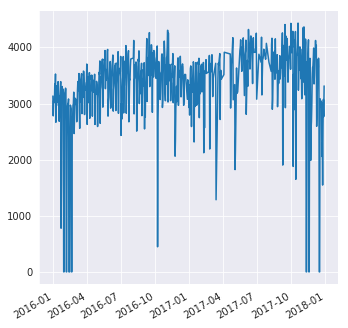

In [68]:
g = sns.relplot(data=df_merged['delent'], kind='line')
g.fig.autofmt_xdate()

In [70]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

ModuleNotFoundError: No module named 'statsmodels'

In [ ]:
test_stationarity(df_merged['delent'])